# Programming Assignment: Бэггинг и случайный лес

Загрузите датасет digits с помощью функции load_digits из sklearn.datasets и подготовьте матрицу признаков X и ответы на обучающей выборке y (вам потребуются поля data и target в объекте, который возвращает load_digits).

Для оценки качества далее нужно будет использовать cross_val_score из sklearn.cross_validation с параметром cv=10. Эта функция реализует k-fold cross validation c k равным значению параметра cv. Мы предлагаем использовать k=10, чтобы полученные оценки качества имели небольшой разброс, и было проще проверить полученные ответы. На практике же часто хватает и k=5. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Для получения среднего значения (которое и будет оценкой качества работы) вызовите метод .mean() у массива, который возвращает cross_val_score.

С небольшой вероятностью вы можете натолкнуться на случай, когда полученное вами качество в каком-то из пунктов не попадет в диапазон, заданный для правильных ответов - в этом случае попробуйте перезапустить ячейку с cross_val_score несколько раз и выбрать наиболее «типичное» значение. Если это не помогает, то где-то была допущена ошибка.

Если вам захочется ускорить вычисление cross_val_score - можете попробовать использовать параметр n_jobs, но будьте осторожны: в одной из старых версий sklearn была ошибка, которая приводила к неверному результату работы cross_val_score при задании n_jobs отличным от 1. Сейчас такой проблемы возникнуть не должно, но проверить, что все в порядке, не будет лишним.


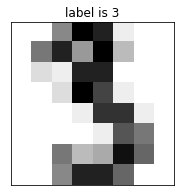

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import model_selection, datasets, ensemble, tree


def plot_number_by_index(ind):
    img_data = X[ind]
    label = y[ind]
    plt.figure(1, figsize=(3, 3))
    plt.imshow(img_data.reshape((8,8)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.title(f"label is {label}")
    plt.show()


dt = datasets.load_digits()
X = dt.data
y = dt.target

plot_number_by_index(3)

__1. Создайте DecisionTreeClassifier с настройками по умолчанию и измерьте качество его работы с помощью cross_val_score. Эта величина и будет ответом в пункте 1.__

In [7]:
cl_er = tree.DecisionTreeClassifier(random_state=0)
scorer_pure_tree = model_selection.cross_val_score(cl_er, X, y, cv=10)
print('1. Cross_val_score (pure tree):', round(scorer_pure_tree.mean(), 5))

1. Cross_val_score (pure tree): 0.82412


__2. Воспользуйтесь BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Используйте в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100.__

Качество классификации новой модели - ответ в пункте 2. Обратите внимание, как соотносится качество работы композиции решающих деревьев с качеством работы одного решающего дерева.

In [8]:
cl_er = tree.DecisionTreeClassifier(random_state=0)
bagging = ensemble.BaggingClassifier(base_estimator=cl_er, random_state=1, n_estimators=100)
scorer_begging = model_selection.cross_val_score(bagging, X, y, cv=10)
print('2. Cross_val_score (begging):', round(scorer_begging.mean(), 5))

2. Cross_val_score (begging): 0.92205


__3. Теперь изучите параметры BaggingClassifier и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех d признаках, а на sqrt(d) случайных признаков.__

Качество работы получившегося классификатора - ответ в пункте 3.
Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три. Но в общем случае ничто не мешает вам выбирать любое другое число случайных признаков.

In [9]:
cl_er = tree.DecisionTreeClassifier(random_state=0)
bagging = ensemble.BaggingClassifier(base_estimator=cl_er, random_state=1, n_estimators=100, max_features=int(np.sqrt(X.shape[1])))
scorer_begging_sqr = model_selection.cross_val_score(bagging, X, y, cv=10)
print('3. Cross_val_score (begging_sqr):', round(scorer_begging_sqr.mean(), 5))

3. Cross_val_score (begging_sqr): 0.93154


__4. Наконец, давайте попробуем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева.__ 
Сделать это несложно: нужно убрать выбор случайного подмножества признаков в BaggingClassifier и добавить его в DecisionTreeClassifier. Какой параметр за это отвечает, можно понять из документации sklearn, либо просто попробовать угадать (скорее всего, у вас сразу получится). Попробуйте выбирать опять же \sqrt{d} 
d
​	  признаков. Качество полученного классификатора на контрольной выборке и будет ответом в пункте 4.

In [10]:
cl_er = tree.DecisionTreeClassifier(random_state=0, max_features=int(np.sqrt(X.shape[1])))
bagging = ensemble.BaggingClassifier(base_estimator=cl_er, random_state=1, n_estimators=100)
scorer_begging_sqr = model_selection.cross_val_score(bagging, X, y, cv=10)
print('4. Cross_val_score (tree_sqr):', round(scorer_begging_sqr.mean(), 5))

4. Cross_val_score (tree_sqr): 0.94991


__5. Полученный в пункте 4 классификатор - бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним).__

Это в точности соответствует алгоритму Random Forest, поэтому почему бы не сравнить качество работы классификатора с RandomForestClassifier из sklearn.ensemble. Сделайте это, а затем изучите, как качество классификации на данном датасете зависит от количества деревьев, количества признаков, выбираемых при построении каждой вершины дерева, а также ограничений на глубину дерева. Для наглядности лучше построить графики зависимости качества от значений параметров, но для сдачи задания это делать не обязательно.

In [11]:
cl_er = ensemble.RandomForestClassifier(random_state=0, n_estimators=150)
scorer_rando_fo = model_selection.cross_val_score(cl_er, X, y, cv=10)
print('5. Cross_val_score (random_fo):', round(scorer_rando_fo.mean(), 5))

5. Cross_val_score (random_fo): 0.94935


__6. Дополнительно. Зависимость точности модели от количества деревьев:__

0.9504624456859092


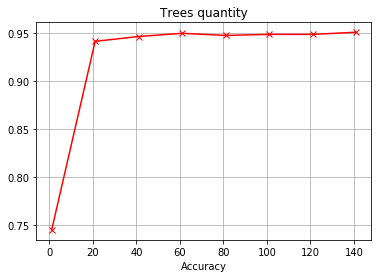

In [12]:
sc=[]
x = range(1,150,20)
for i in x:
    cl_er = ensemble.RandomForestClassifier(random_state=0, n_estimators=i)
    scorer_rando_fo = model_selection.cross_val_score(cl_er, X, y, cv=10)
    sc.append(scorer_rando_fo.mean())
print(sc[-1])
plt.plot(x,sc,'r-', marker='x')
plt.title('Trees quantity')
plt.xlabel('Trees quantity')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

__7. Дополнительно. Зависимость точности модели от количества признаков:__

0.9504655493482309


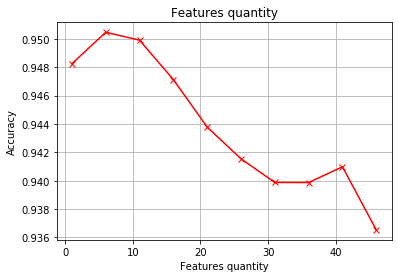

In [17]:
sc=[]
x = range(1,50,5)
for i in x:
    cl_er = ensemble.RandomForestClassifier(random_state=0, n_estimators=150, max_features=i)
    scorer_rando_fo = model_selection.cross_val_score(cl_er, X, y, cv=10)
    sc.append(scorer_rando_fo.mean())
print(sc[1])
plt.plot(x,sc,'r-', marker='x')
plt.title('Features quantity')
plt.xlabel('Features quantity')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

__8. Дополнительно. Зависимость точности модели от глубины деревьев:__

0.9504624456859092


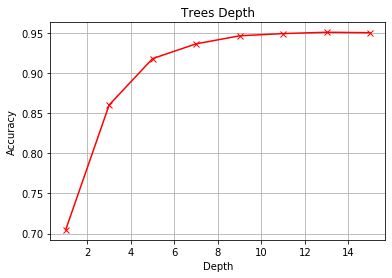

In [18]:
sc=[]
x = range(1,16,2)
for i in x:
    cl_er = ensemble.RandomForestClassifier(random_state=0, n_estimators=150, max_features=6, max_depth=i)
    scorer_rando_fo = model_selection.cross_val_score(cl_er, X, y, cv=10)
    sc.append(scorer_rando_fo.mean())
print(sc[-1])
plt.plot(x,sc,'r-', marker='x')
plt.title('Trees Depth')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

На основе наблюдений выпишите через пробел номера правильных утверждений из приведенных ниже в порядке возрастания номера (это будет ответ в п.5)

1) Случайный лес сильно переобучается с ростом количества деревьев

2) При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев

3) С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется.

4) При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.

5) При большом количестве признаков (40, 50, 60) качество классификации лучше, чем при малом количестве признаков (5, 10). Это связано с тем, что чем больше признаков - тем больше информации об объектах, а значит алгоритм может делать прогнозы более точно.

6) При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса намного лучше, чем без ограничения глубины, т.к. деревья получаются не переобученными. С ростом глубины деревьев качество ухудшается.

7) При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга).

2 3 4 7